# 머신러닝 회귀(Regression) 실습 : Sklearn boston 집값 예측

In [48]:
from sklearn.datasets import load_boston

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

In [2]:
dataset = load_boston()
# X, y = load_boston(return_X_y=True)

df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df["target"]=dataset.target #kaggle feature MEDV
X_df = df.iloc[:,:-1]
y_df = df.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.2, shuffle=True, random_state=36)

## 데이터 확인

In [3]:
df.info() #결측없고 수치형 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [4]:
df.head()
#수치가 너무 달라서 스케일링 필요

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
df.describe()
#CHAS 이산형 데이터 확인
#가격과 같은 데이터들은 로그 스케일 사용 (수치 변화가 급격할 때 변화율을 보기에 적합)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 피처 확인
[01]  CRIM 자치시(town) 별 1인당 범죄율 <br>
[02]  ZN 25,000 평방피트를 초과하는 거주지역의 비율 <br>
[03]  INDUS 비소매상업지역이 점유하고 있는 토지의 비율 <br>
[04]  CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0) <br>
[05]  NOX 10ppm 당 농축 일산화질소 <br>
[06]  RM 주택 1가구당 평균 방의 개수 <br>
[07]  AGE 1940년 이전에 건축된 소유주택의 비율 <br>
[08]  DIS 5개의 보스턴 직업센터까지의 접근성 지수 <br>
[09]  RAD 방사형 도로까지의 접근성 지수 <br>
[10]  TAX 10,000 달러 당 재산세율 <br>
[11]  PTRATIO 자치시(town)별 학생/교사 비율 <br>
[12]  B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함. <br>
[13]  LSTAT 모집단의 하위계층의 비율(%) <br>
[14]  MEDV -> target 본인 소유의 주택가격(중앙값) (단위: $1,000)


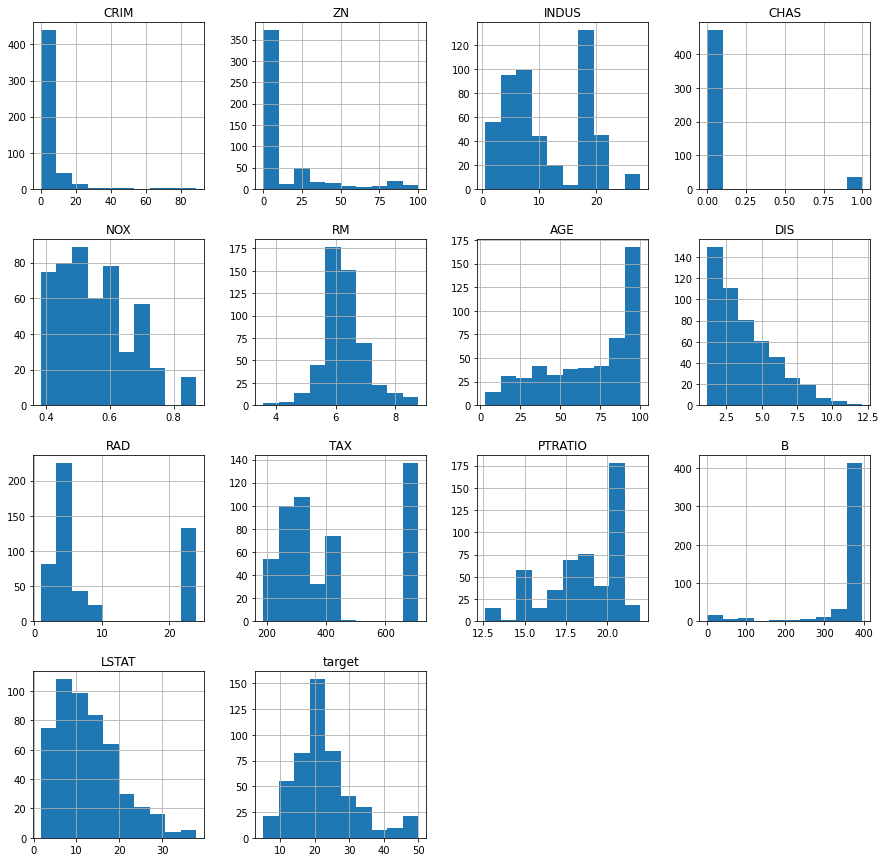

In [6]:
df.hist(figsize=(15,15))
plt.show()

## 일단 점수 보기

In [7]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
pred = model1.predict(X_val)
mse = mean_squared_error(y_val, pred, squared=True)
rmse = mean_squared_error(y_val, pred, squared=False)
print(f'MSE:{mse:.5f} RMSE:{rmse:.5f}')

MSE:27.62735 RMSE:5.25617


## Preprocessing (전처리)

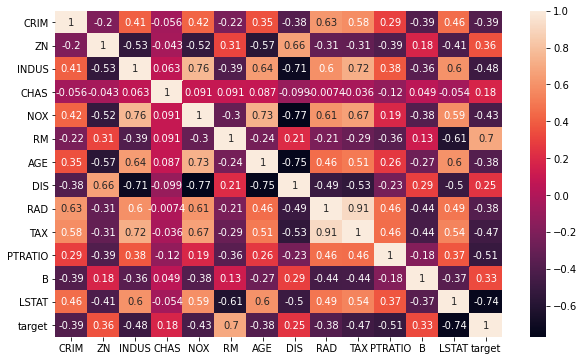

In [8]:
#상관분석
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.show()
#Target과는 LSTAT/RM의 영향력이 제일 크다
#CRIM/RAD와 같이 상관도가 0.5이상이면 다중공선에 걸릴 우려가 매우 크다(거의 백퍼센트)

In [9]:
corr_df = df.corr()
corr_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [10]:
df.corrwith(df["target"]).sort_values(ascending=False)
#주요피처
# RM         0.695360
# ZN         0.360445
# B          0.333461

# NOX       -0.427321
# TAX       -0.468536
# INDUS     -0.483725
# PTRATIO   -0.507787
# LSTAT     -0.737663

target     1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
dtype: float64

In [11]:
nfeature = ["RM", "ZN", "B", "NOX", "TAX", "INDUS", "PTRATIO", "LSTAT"]

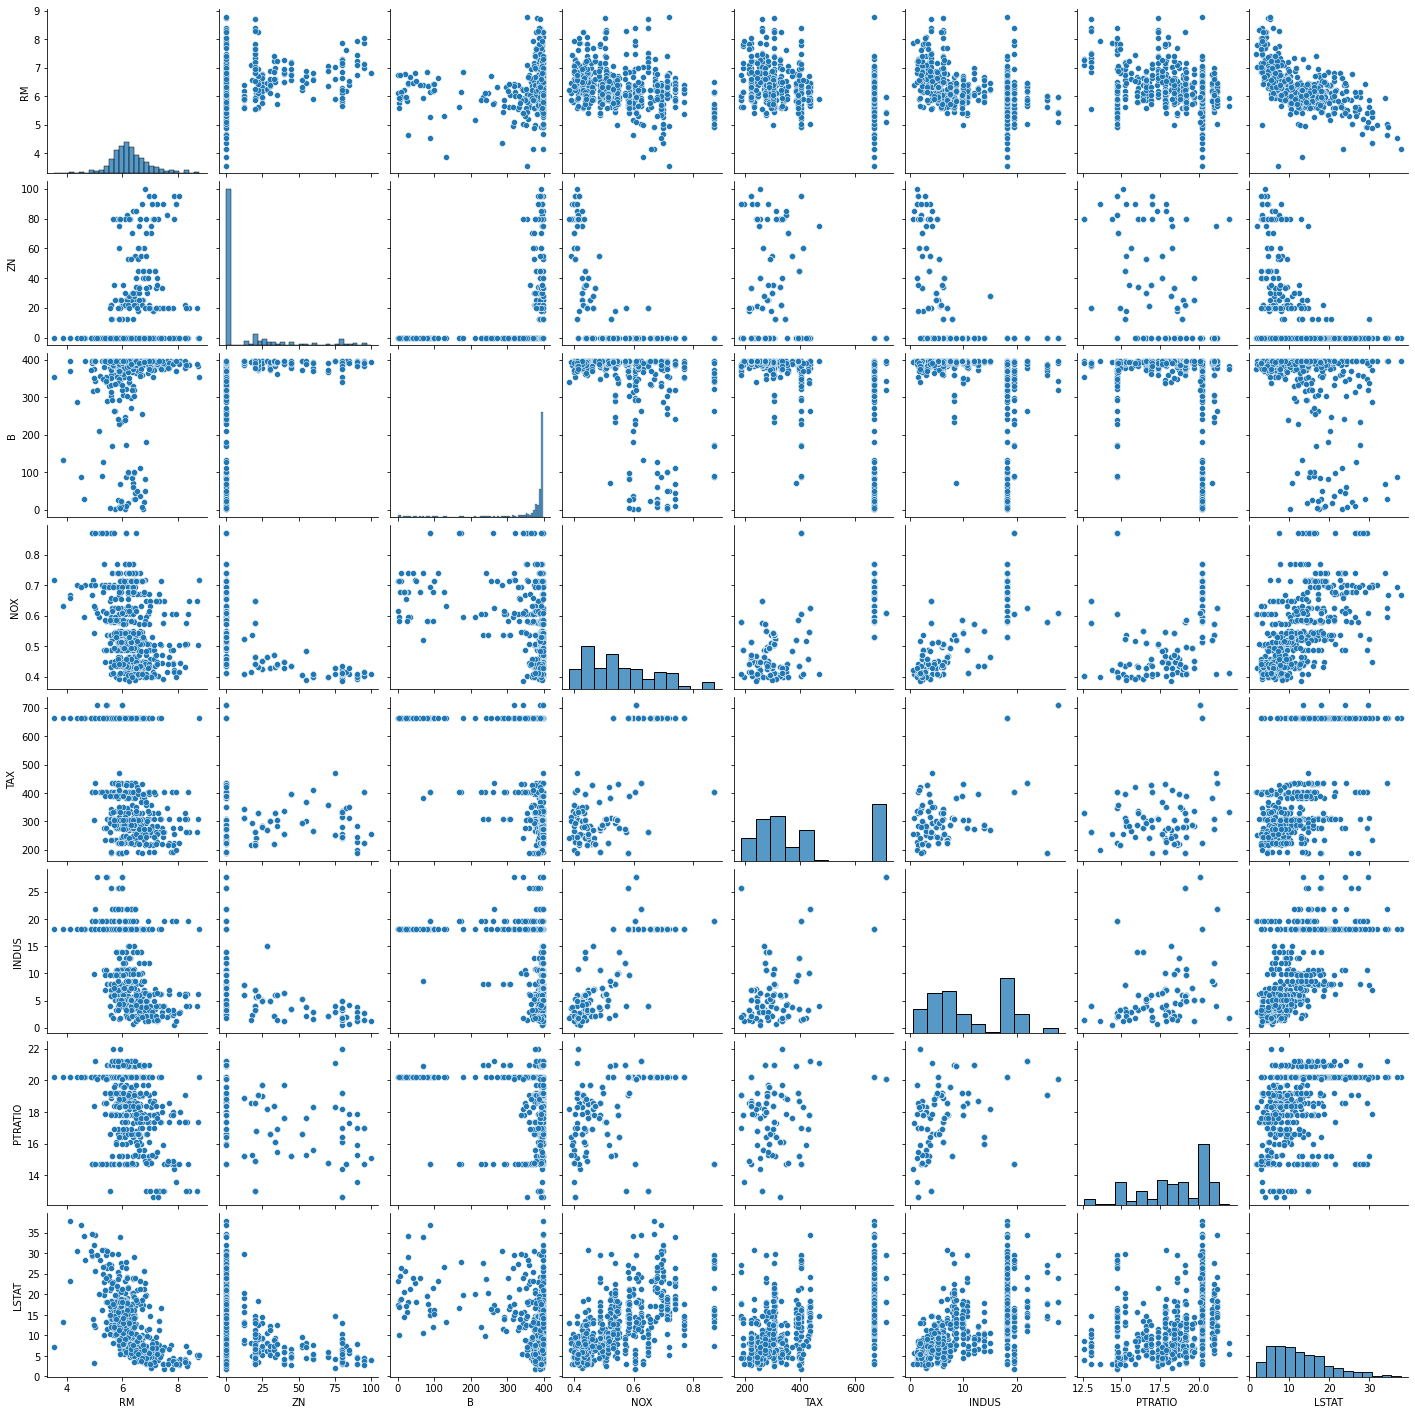

In [12]:
sns.pairplot(df[nfeature])

In [13]:
# pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

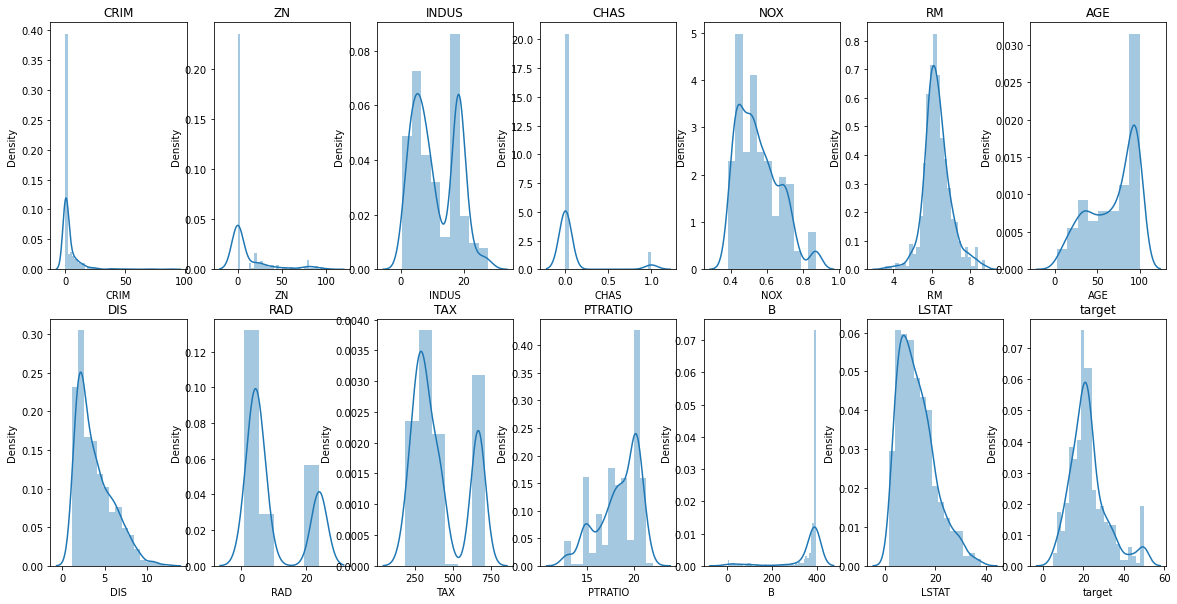

In [14]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
for i, feature in enumerate(df.columns):
    cols = i%7
    rows = i//7     
    sns.distplot(df[feature], kde=True, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)

In [15]:
#스케일 처리 >> 카테고리성 'CHAS' 제외
scale_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'target']
for sf in scale_features:
    df[sf] = np.log1p(df[sf])
    
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.006300,2.944439,1.196948,0.0,0.430483,2.024853,4.192680,1.627278,0.693147,5.693732,2.791165,5.986201,1.788421,3.218876
1,0.026944,0.000000,2.088153,0.0,0.384582,2.004314,4.380776,1.786261,1.098612,5.493061,2.933857,5.986201,2.316488,3.117950
2,0.026924,0.000000,2.088153,0.0,0.384582,2.102303,4.128746,1.786261,1.098612,5.493061,2.933857,5.975919,1.615420,3.575151
3,0.031857,0.000000,1.156881,0.0,0.377066,2.079192,3.845883,1.954757,1.386294,5.407172,2.980619,5.980479,1.371181,3.538057
4,0.066770,0.000000,1.156881,0.0,0.377066,2.097650,4.010963,1.954757,1.386294,5.407172,2.980619,5.986201,1.845300,3.616309


### 스케일링 점수 확인

In [16]:
X_df = df.iloc[: , :-1]
y_df = df.iloc[: , -1]
X_train , X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.2, shuffle=True, random_state=121)
print(X_train.shape , y_train.shape,X_val.shape,  y_val.shape )

model1 = LinearRegression()
model1.fit(X_train, y_train)
pred = model1.predict(X_val)
mse = mean_squared_error(y_val, pred, squared=True)
rmse = mean_squared_error(y_val, pred, squared=False)
print(f'MSE:{mse:.5f}  RMSE:{rmse:.5f}')
# MSE:27.62735 RMSE:5.25617
# MSE:0.03310  RMSE:0.18193 >> 오차 확연히 축소 >> 오버피팅 의심

(404, 13) (404,) (102, 13) (102,)
MSE:0.03310  RMSE:0.18193


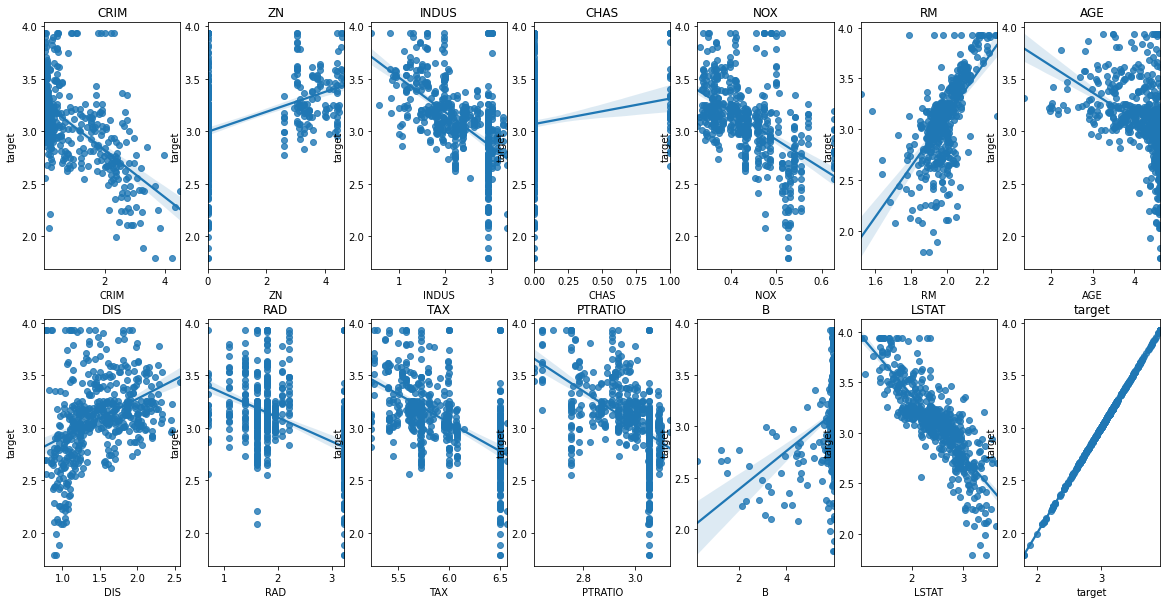

In [17]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
for i, feature in enumerate(df.columns):
    cols = i%7
    rows = i//7     
    sns.regplot(y=df['target'], x=df[feature], ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)
    
#기울기가 크다 >> 회귀계수가 크다

In [30]:
coef_df = pd.DataFrame(model1.coef_, index=X_df.columns, columns=["coef"])
coef_df["corr"] = df.corrwith(df["target"])

coef_df.sort_values(by="coef", ascending=False)
#corr보다는 coef를 보는 것이 더 정확하다

,coef,corr
RM,0.504180,0.619280
RAD,0.152296,-0.444867
CHAS,0.112194,0.159435
B,0.051098,0.351096
AGE,0.021723,-0.391441
ZN,-0.006136,0.400188
INDUS,-0.010159,-0.558975
CRIM,-0.120273,-0.594500
TAX,-0.151109,-0.555187
DIS,-0.228332,0.390719


### 오버피팅을 막기 위한 규제 적용

- Lasso : L1 규제 a|W|, 분석에 선별되는 피쳐수 줄이기  
    target에 중요도가 덜한 피쳐들은 규제 적용하면 w=0  
    대상에서 제외 > 예측에서 안정적으로 사용되어질 피쳐  
- Ridge : L2 규제 aW^2, 피쳐수 그대로, 덜 중요한 피쳐의 w가 작아짐  
    target에 중요도가 덜한 피쳐들은 규제 적용하면 w들은 0에 근사

In [34]:
# LinearRegression()
lasso = Lasso(alpha=1.0) # a*|W|
ridge = Ridge(alpha=1.0) # a*W^2
elsnet = ElasticNet(alpha=1.0, l1_ratio=0.2) # 0.2(a*|W|) + 0.8(a*W^2)

In [39]:
models = [lasso, ridge, elsnet]
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred, squared=True)
    rmse = mean_squared_error(y_val, pred, squared=False)
    print(f"{model.__class__.__name__} MSE:{mse:.5f} RMSE:{rmse:.5f}")
# Lasso MSE:0.13108 RMSE:0.36205
# Ridge MSE:0.03366 RMSE:0.18348

Lasso MSE:0.13108 RMSE:0.36205
Ridge MSE:0.03366 RMSE:0.18348
ElasticNet MSE:0.11899 RMSE:0.34495


In [56]:
for model in models:
    score_list = cross_val_score(model, X_df, y=y_df, scoring="neg_mean_squared_error", cv=5)
    score_list = -1*score_list

print(score_list, score_list.mean())

[0.05450471 0.11716732 0.20333358 0.21135399 0.23766554] 0.16480502873757988


In [55]:
for model in models:
    score_list = cross_validate(model, X_df, y=y_df,
                                scoring={"mse":"neg_mean_squared_error",
                                        "rmse":"neg_root_mean_squared_error"},
                                return_train_score=False, cv=5)

    mse_score = score_list["test_mse"]*-1
    rmse_score = score_list["test_rmse"]*-1
    print(f"{model.__class__.__name__} MSE:{mse_score.mean():.5f} RMSE:{rmse_score.mean():.5f}")
# Lasso MSE:0.17264 RMSE:0.40510
# Ridge MSE:0.03931 RMSE:0.18956

Lasso MSE:0.17264 RMSE:0.40510
Ridge MSE:0.03931 RMSE:0.18956
ElasticNet MSE:0.16481 RMSE:0.39479


In [62]:
cv_model =GridSearchCV(ridge, param_grid={"alpha":[0.01, 1.0, 5.0, 10.0]},
                       scoring="neg_root_mean_squared_error", cv=5, refit=True)

cv_model.fit(X_train, y_train)
print(f"RMSE:{cv_model.best_score_*-1:.5f}")
print(cv_model.best_params_)

RMSE:0.17835
{'alpha': 0.01}


In [82]:
#알파값 변화에 따른 coef(회귀계수) 확인
alpha = [0.01, 1.0, 5.0, 10.0, 100.0]
coef_df = pd.DataFrame()
for a in alpha:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_val)
    score = mean_squared_error(y_val, pred, squared=False)    
    coef_df["alpha"+str(a)]=ridge.coef_
    print(f"alpha:{a} \t RMSE:{score:.4f}")
    
coef_df.index=X_train.columns

alpha:0.01	 RMSE:0.1819
alpha:1.0	 RMSE:0.1835
alpha:5.0	 RMSE:0.1889
alpha:10.0	 RMSE:0.1937
alpha:100.0	 RMSE:0.2393


In [80]:
coef_df

,alpha0.01,alpha1.0,alpha5.0,alpha10.0,alpha100.0
CRIM,-0.120477,-0.125558,-0.121688,-0.116081,-0.087219
ZN,-0.006031,-0.001200,0.003264,0.004608,0.015814
INDUS,-0.010732,-0.030979,-0.044049,-0.048885,-0.052904
CHAS,0.112074,0.110445,0.111466,0.107753,0.049626
NOX,-0.884867,-0.244520,-0.049872,-0.022060,-0.004472
RM,0.501450,0.335452,0.176135,0.128925,0.040929
AGE,0.021536,0.019170,0.021366,0.019733,-0.012602
DIS,-0.226995,-0.189417,-0.164411,-0.140815,-0.028098
RAD,0.152156,0.142963,0.117694,0.097152,0.007397
TAX,-0.151577,-0.158701,-0.132113,-0.108080,-0.041993


In [96]:
alpha = [0.01, 1.0, 5.0, 10.0, 100.0]
coef_df = pd.DataFrame()
for a in alpha:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_val)
    score = mean_squared_error(y_val, pred, squared=False)    
    coef_df["alpha"+str(a)]=lasso.coef_
    print(f"alpha:{a} \t RMSE:{score:.4f}")
    
coef_df.index=X_train.columns

alpha:0.01 	 RMSE:0.2164
alpha:1.0 	 RMSE:0.3620
alpha:5.0 	 RMSE:0.3620
alpha:10.0 	 RMSE:0.3620
alpha:100.0 	 RMSE:0.3620


In [98]:
coef_df
#l1 규제를 가했을 때 규제가 0이 되는 것이 분석에 주요하게 사용되는 피쳐

,alpha0.01,alpha1.0,alpha5.0,alpha10.0,alpha100.0
CRIM,-0.067483,-0.0,-0.0,-0.0,-0.0
ZN,0.000000,0.0,0.0,0.0,0.0
INDUS,-0.000000,-0.0,-0.0,-0.0,-0.0
CHAS,0.029835,0.0,0.0,0.0,0.0
NOX,0.000000,-0.0,-0.0,-0.0,-0.0
RM,0.000000,0.0,0.0,0.0,0.0
AGE,0.015090,-0.0,-0.0,-0.0,-0.0
DIS,-0.013215,0.0,0.0,0.0,0.0
RAD,0.000000,-0.0,-0.0,-0.0,-0.0
TAX,-0.000000,-0.0,-0.0,-0.0,-0.0


In [103]:
#coef_df에서 확인 것으로 불필요한 피쳐 제거 후 점수 확인
topn = ["ZN","INDUS","NOX","RM","RAD","TAX","PTRATIO"]

lasso = Lasso(alpha=0.01)
lasso.fit(X_train[topn], y_train)
pred = lasso.predict(X_val[topn])
score = mean_squared_error(y_val, pred, squared=False)
print(f"alpha:0.01 \t RMSE:{score:.5f}")

alpha:0.01 	 RMSE:0.29033


## 스케일링한 데이터에서 원본값 추출

In [105]:
pred = cv_model.predict(X_val)
print(pred[:5])
predo = np.round(np.expm1(pred),1)
print(predo[:5])

[3.54098252 3.63115473 3.78747357 3.27430558 3.49859579]
[33.5 36.8 43.1 25.4 32.1]
